In [1]:
import sys
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import time

# Add the parent directory to the Python path
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))
# Now you can use absolute imports
from src.utils.data_processing import preprocess_data
from src.utils.defaults import DEFAULTS, DIAMETER_DICT, THICKNESS_DICT, FLOWRATE_DICT, TEMPERATURE_DICT
from src.models.single_pressure.variable_diffusivity_fvt.plotting import (
    plot_diffusivity_profile,
    plot_diffusivity_location_profile,
    plot_norm_flux_over_tau,
    plot_norm_flux_over_time
)

# Solve ODE for new step

In [2]:
from scipy.integrate import solve_ivp

def _solve_pde(previous_D1_prime, D1_prime, DT_0, T, X, L, dx, 
                D2_prime=1.0, rel_tol=1e-8, atol=None,
                dt_init=0.0005, track_solving_progress=True,
                D0=None):  # Removed unused parameters
    # Discretize space
    Nx = int(X / dx) + 1
    x = np.linspace(0, X, Nx)
    K = DT_0 / (L * L)
    
    # Define the ODE system derived from Method of Lines
    def diffusion_ode(t, D):
        """Convert PDE to system of ODEs using Method of Lines"""
        dDdt = np.zeros_like(D)
        dx2 = dx * dx
        
        # Apply interior points dynamics
        for i in range(1, len(D)-1):
            lapl = (D[i+1] - 2.0*D[i] + D[i-1]) / dx2
            dDdt[i] = K * D[i] * lapl
        
        # Boundary conditions
        dDdt[0] = 0  # Fixed D1_prime (Dirichlet)
        dDdt[-1] = 0  # Fixed D2_prime (Dirichlet)
        
        return dDdt
    
    # Initial condition
    if D0 is None:
        # D0 = np.ones(Nx, dtype=np.float64)
        #* Use linear space for initial condition
        D0 = np.linspace(previous_D1_prime, D2_prime, Nx, dtype=np.float64)
        
        D0[0] = D1_prime     # Left boundary
        D0[-1] = D2_prime    # Right boundary
    else:
        # Ensure boundary conditions are properly set in provided D0
        D0[0] = D1_prime
        D0[-1] = D2_prime
    
    # Configuration for the solver
    if atol is None:
        atol = rel_tol * 0.1  # Set absolute tolerance based on relative tolerance
    
    # Track solution timing if progress tracking is enabled
    if track_solving_progress:
        start_time = time.time()
        print(f"Starting solve_ivp integration (D1'={D1_prime:.2f}, DT0={DT_0:.2e})...")
        
    # Solve using solve_ivp with BDF method (good for stiff problems)
    solution = solve_ivp(
        diffusion_ode, 
        t_span=[0, T],
        y0=D0,
        method='BDF',  # Backward Differentiation Formula (for stiff problems)
        rtol=rel_tol,
        atol=atol,
        first_step=dt_init,  # Initial step hint
        max_step=T/10,  # Use reasonable max step based on total time
        dense_output=True  # Allow interpolation for output
    )
    
    if track_solving_progress:
        end_time = time.time()
        solve_time = end_time - start_time
        print(f"Integration complete. Time taken: {solve_time:.4f} seconds")
        print(f"Number of function evaluations: {solution.nfev}")
        print(f"Number of Jacobian evaluations: {solution.njev}")
        print(f"Solver status: {solution.status} (0=success)")
    
    # Extract solution information - get more points for smoother output
    num_output_points = min(1000, max(100, int(T/10)))  # Adaptive number of output points
    t_eval = np.linspace(0, T, num_output_points)
    D_history = []
    
    for t in t_eval:
        D_t = solution.sol(t)
        D_history.append(D_t)
    
    D_arr = np.array(D_history)
    
    # Calculate normalized flux
    F_norm = (-(D_arr[:, -1] - D_arr[:, -2]) / dx) / (-(D2_prime - D1_prime) / X)
    
    # Create DataFrames for output
    Dprime_df = pd.DataFrame(D_arr, columns=[f"x={xi:.3f}" for xi in x], index=t_eval)
    flux_df = pd.DataFrame({
        "time": t_eval,
        "normalised_flux": F_norm,
        "tau": DT_0 * t_eval / (L * L)
    })
    
    return Dprime_df, flux_df

In [3]:
def calculate_plot_step_results(step_data, previous_D1_prime, new_D1_prime, new_DT_0, T, L, display_plot=True):
    # Solver with solve_ivp
    Dprime_df, flux_df = _solve_pde(
        previous_D1_prime=previous_D1_prime,
        D1_prime=new_D1_prime,
        DT_0=new_DT_0,
        T=T,
        X=1.0,
        L=L,
        dx=0.01,
        dt_init=0.001,
        rel_tol=1e-8,
        atol=None,
        track_solving_progress=False
    )

    # Create plots
    figures = {}

    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))    # 2x2 plot

    # Plot concentration profile evolution
    plot_diffusivity_profile(
        diffusivity_profile=Dprime_df,
        ax=ax1,
        display=False
    )

    # Plot concentration-location profiles
    plot_diffusivity_location_profile(
        diffusivity_profile=Dprime_df,
        L=L,
        T=T,
        ax=ax2,
        display=False
    )

    # Plot flux evolution
    plot_norm_flux_over_tau(
        flux_data=flux_df,
        experimental_data=step_data,
        ax=ax3,
        display=False
    )

    plot_norm_flux_over_time(
        flux_data=flux_df,
        experimental_data=step_data,
        ax=ax4,
        display=False
    )

    plt.tight_layout()
    if display_plot:
        plt.show()
    else:
        plt.close(fig)
    
    return fig, (ax1, ax2, ax3, ax4), Dprime_df, flux_df

In [4]:
def process_step_exp_data(full_data, time_range, thickness, DT_0):

    step_data = full_data[
        (full_data['time'] >= time_range[0]) &
        (full_data['time'] <= time_range[1])
    ].copy()
    step_data['time'] -= time_range[0]  # Normalize time to start from 0
    T = step_data['time'].max() # [s]

    # Add normalised flux
    step_data['rolling_avg'] = step_data['flux'].rolling(window=10, center=True).mean()
    rolling_avg_max = step_data['flux'].rolling(window=10, center=True).mean().max()
    step_data['normalised_flux'] = step_data['flux'] / rolling_avg_max
    step_data['tau'] = DT_0 * step_data['time'] / thickness**2
    step_data = step_data[['time', 'flux', 'normalised_flux', 'yCO2_bl', 'pressure', 'tau']]
    
    return step_data, T

## Model `t_i=0` when pressure first applied

### S4R5

In [21]:
experiment = 'S4R5'
data_path = Path.cwd().parent / 'data' / 'multi_pressure' / f'{experiment}.xlsx'
exp_data = pd.read_excel(data_path)
processed_data = preprocess_data(
    data=exp_data, 
    temperature= TEMPERATURE_DICT[experiment],
    thickness= THICKNESS_DICT[experiment], 
    flowrate= FLOWRATE_DICT[experiment],
    diameter= DIAMETER_DICT[experiment]
    )

# Export
# processed_data.to_csv(Path.cwd().parent / 'data' / 'multi_pressure' / f'{experiment}_processed.csv', index=False)

Step 2 (100 bar).

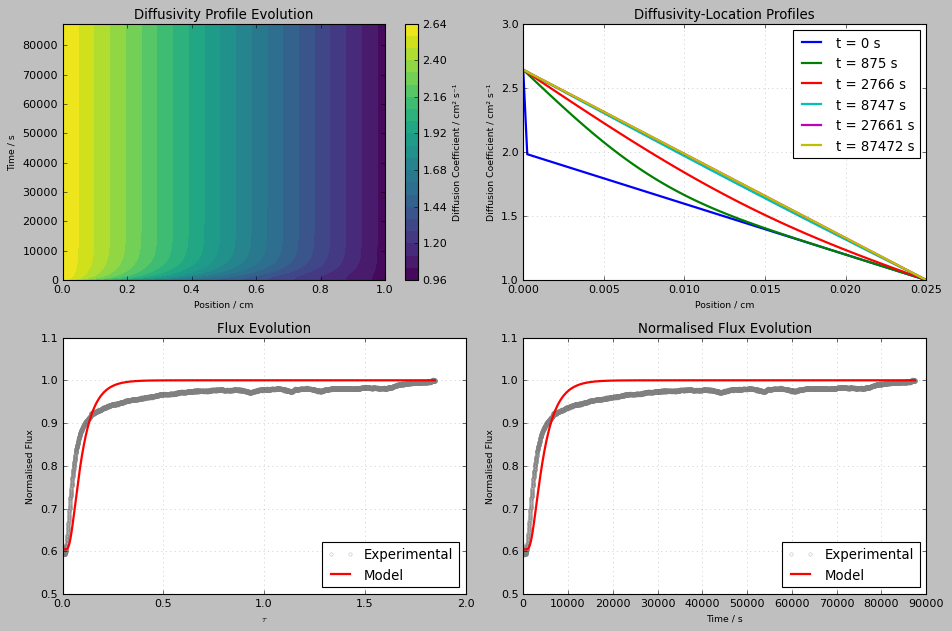

In [ ]:
# From anlaysis
thickness = THICKNESS_DICT[experiment]
new_D1_prime = 2.639368593
previous_D1_prime = 1.990930572
DT_0 = 1.32E-08

# Get step data
step_2_exp_data, T = process_step_exp_data(
    full_data=processed_data, 
    time_range = [90522.2999997139, 178e3], # earlier time
    thickness=thickness, 
    DT_0=DT_0,
    )

# Run step analysis
calculate_plot_step_results(
    step_data=step_2_exp_data,
    previous_D1_prime=previous_D1_prime,
    new_D1_prime=new_D1_prime,
    new_DT_0=DT_0,
    T=T,
    L=thickness
)

Step 3 (150 bar).

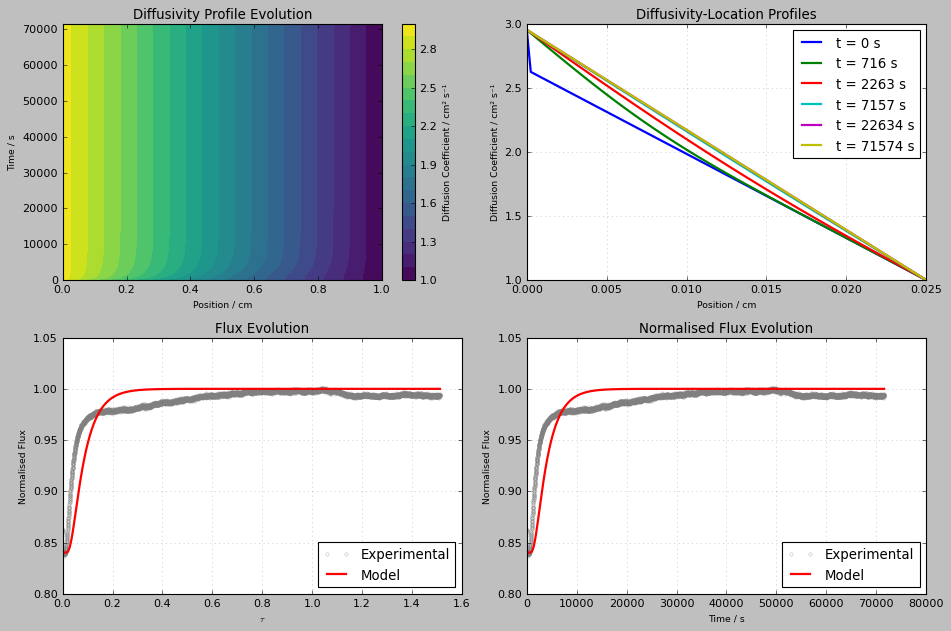

In [ ]:
# From anlaysis
thickness = THICKNESS_DICT[experiment]
previous_D1_prime = 2.639368593
new_D1_prime = 2.950834743
DT_0 = 1.32E-08

# Get step data
step_3_exp_data, T = process_step_exp_data(
    full_data=processed_data, 
    time_range = [178423.8, 180e3+70e3], # earlier time
    thickness=thickness, 
    DT_0=DT_0,
    )

# Run step analysis
calculate_plot_step_results(
    step_data=step_3_exp_data,
    previous_D1_prime=previous_D1_prime,
    new_D1_prime=new_D1_prime,
    new_DT_0=DT_0,
    T=T,
    L=thickness
)

Step 4 (200 bar).

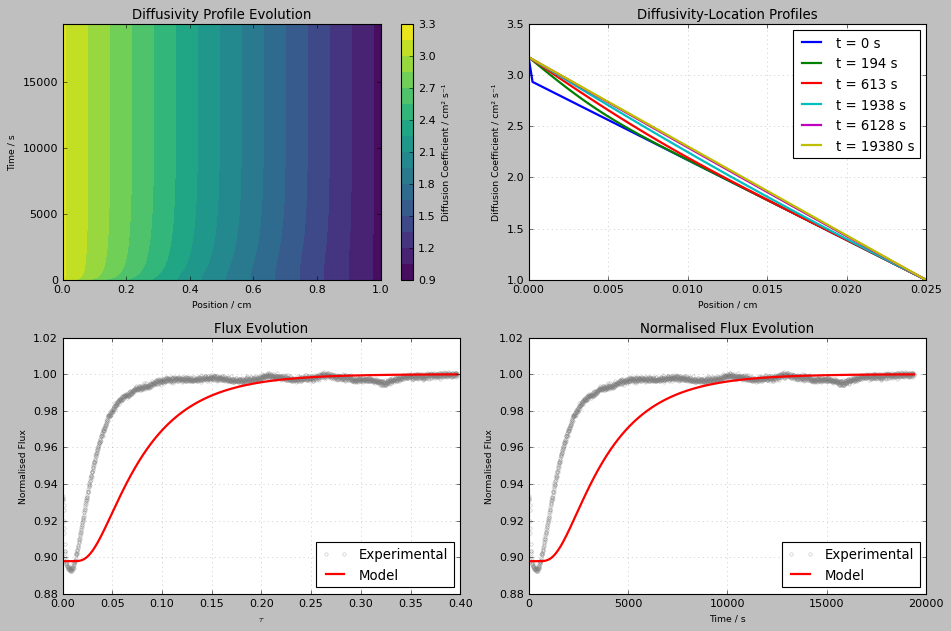

In [ ]:
# From anlaysis
thickness = THICKNESS_DICT[experiment]
previous_D1_prime = 2.950834743
new_D1_prime = 3.172677115
DT_0 = 1.28E-08

# Get step data
step_4_data, T = process_step_exp_data(
    full_data=processed_data, 
    time_range = [348619.9, 368e3], # earlier time
    thickness=thickness, 
    DT_0=DT_0,
    )

# Run step analysis
calculate_plot_step_results(
    step_data=step_4_data,
    previous_D1_prime=previous_D1_prime,
    new_D1_prime=new_D1_prime,
    new_DT_0=DT_0,
    T=T,
    L=thickness
)

### S4R6

In [25]:
experiment = 'S4R6'
data_path = Path.cwd().parent / 'data' / 'multi_pressure' / f'{experiment}.xlsx'
exp_data = pd.read_excel(data_path)
processed_data = preprocess_data(
    data=exp_data, 
    temperature= TEMPERATURE_DICT[experiment],
    thickness= THICKNESS_DICT[experiment], 
    flowrate= FLOWRATE_DICT[experiment],
    diameter= DIAMETER_DICT[experiment]
    )

# Export
# processed_data.to_csv(Path.cwd().parent / 'data' / 'multi_pressure' / f'{experiment}_processed.csv', index=False)

Step 2 (100 bar).

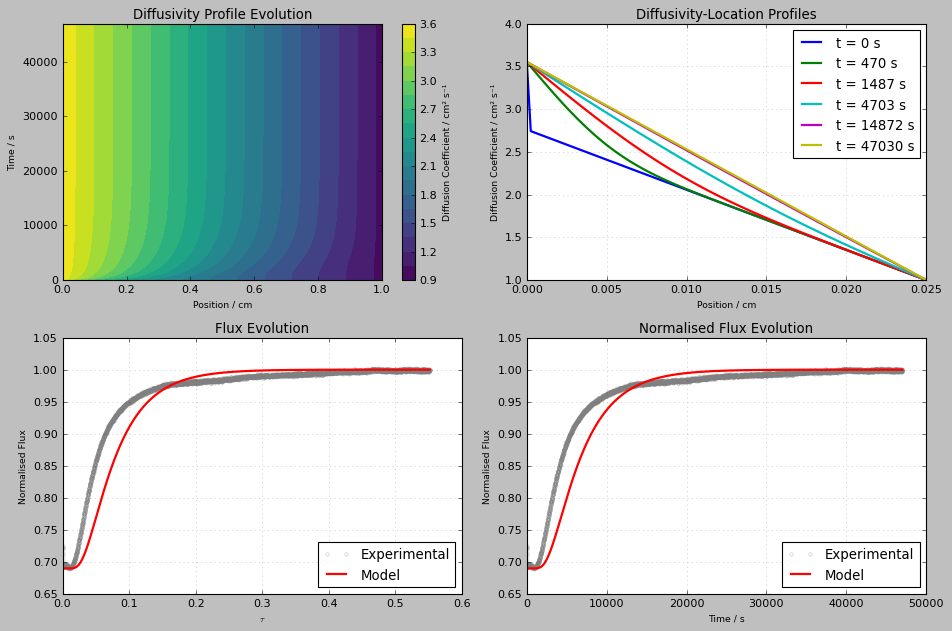

In [ ]:
# From anlaysis
thickness = THICKNESS_DICT[experiment]
previous_D1_prime = 2.759069935
new_D1_prime = 3.54960978
DT_0 = 7.33E-09

# Get step data
step_2_exp_data, T = process_step_exp_data(
    full_data=processed_data,
    time_range = [102446.7, 149478.22], # earlier time
    thickness=thickness, 
    DT_0=DT_0,
    )

# Run step analysis
calculate_plot_step_results(
    step_data=step_2_exp_data,
    previous_D1_prime=previous_D1_prime,
    new_D1_prime=new_D1_prime,
    new_DT_0=DT_0,
    T=T,
    L=thickness
)

Step 3 (150 bar).

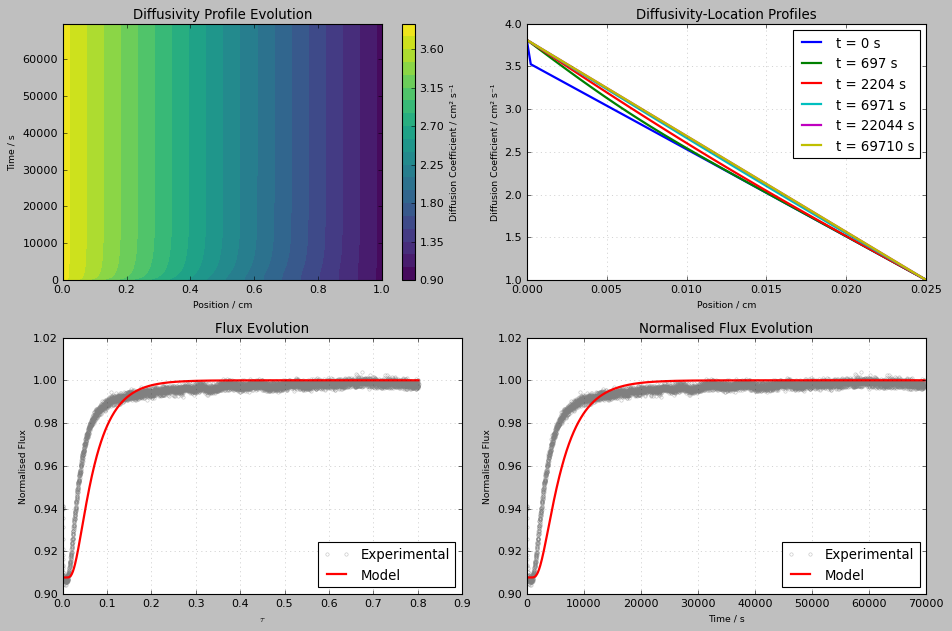

In [ ]:
# From anlaysis
thickness = THICKNESS_DICT[experiment]
previous_D1_prime = 3.54960978
new_D1_prime = 3.808778288
DT_0 = 7.19E-09

# Get step data
step_3_exp_data, T = process_step_exp_data(
    full_data=processed_data, 
    time_range = [180285.9, 250000],    # earlier time
    thickness=thickness, 
    DT_0=DT_0,
    )

# Run step analysis
calculate_plot_step_results(
    step_data=step_3_exp_data,
    previous_D1_prime=previous_D1_prime,
    new_D1_prime=new_D1_prime,
    new_DT_0=DT_0,
    T=T,
    L=thickness
)

Step 4 (200 bar).

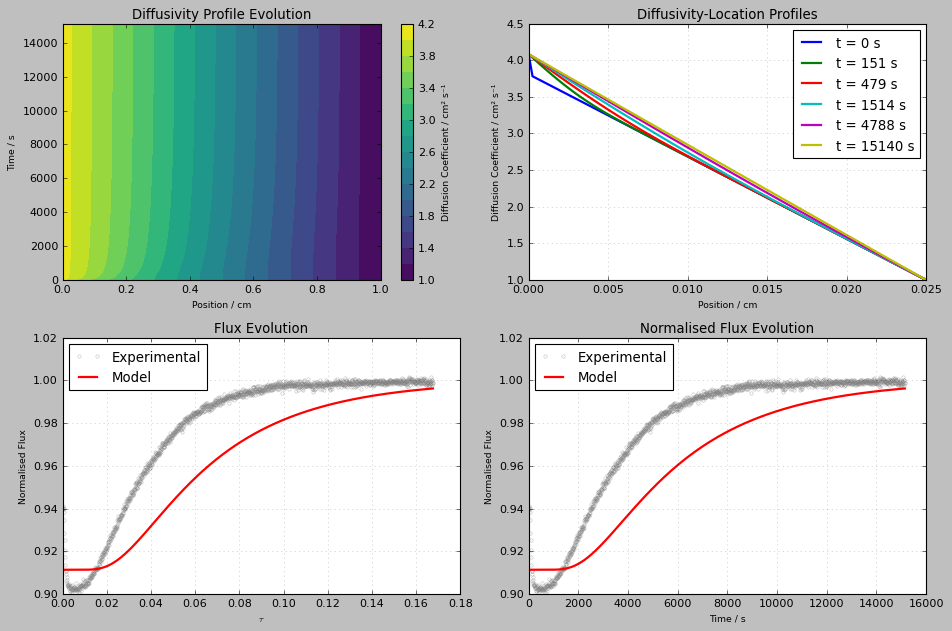

In [ ]:
# From anlaysis
thickness = THICKNESS_DICT[experiment]
previous_D1_prime = 3.808778288
new_D1_prime = 4.082026754
DT_0 = 6.92E-09

# Get step data
step_4_data, T = process_step_exp_data(
    full_data=processed_data, 
    time_range = [264851.3, 280e3], # earlier time
    thickness=thickness, 
    DT_0=DT_0,
    )

# Run step analysis
calculate_plot_step_results(
    step_data=step_4_data,
    previous_D1_prime=previous_D1_prime,
    new_D1_prime=new_D1_prime,
    new_DT_0=DT_0,
    T=T,
    L=thickness
)

# Concatenate all time steps

### S4R5

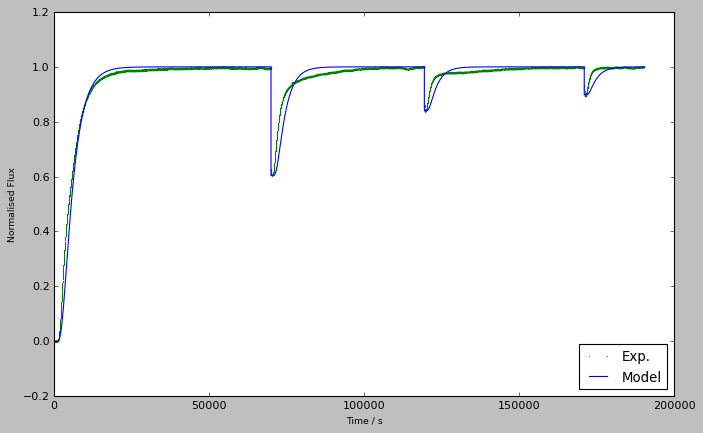

In [9]:
# Process exp data
experiment = 'S4R5'
thickness = THICKNESS_DICT[experiment]
data_path = Path.cwd().parent / 'data' / 'multi_pressure' / f'{experiment}.xlsx'
exp_data = pd.read_excel(data_path)
processed_data = preprocess_data(
    data=exp_data, 
    temperature= TEMPERATURE_DICT[experiment],
    thickness= THICKNESS_DICT[experiment], 
    flowrate= FLOWRATE_DICT[experiment],
    diameter= DIAMETER_DICT[experiment]
)

#----------------
# Step 1
#----------------
previous_D1_prime = 1.00
new_D1_prime = 1.990930572
DT_0 = 1.33E-08
step_1_data, T = process_step_exp_data(
    full_data=processed_data, 
    time_range = [0, 70e3], #* tune 
    thickness=thickness, 
    DT_0=DT_0,
)
combined_exp_data = step_1_data.copy()

_, _, _, flux_df = calculate_plot_step_results(
    step_data=step_1_data,
    previous_D1_prime=previous_D1_prime,
    new_D1_prime=new_D1_prime,
    new_DT_0=DT_0,
    T=T,
    L=thickness,
    display_plot=False
)
combined_model_data = flux_df.copy()

#----------------
# Step 2
#----------------
new_D1_prime = 2.639368593
previous_D1_prime = 1.990930572
DT_0 = 1.33E-08

step_2_exp_data, T = process_step_exp_data(
    full_data=processed_data, 
    time_range = [90522.2999997139, 140e3], #* tune 
    thickness=thickness, 
    DT_0=DT_0,
)
step_2_exp_data_adjusted = step_2_exp_data.copy()
step_2_exp_data_adjusted['time'] += combined_exp_data['time'].max()
combined_exp_data = pd.concat([combined_exp_data, step_2_exp_data_adjusted], ignore_index=True)

_, _, _, flux_df = calculate_plot_step_results(
    step_data=step_2_exp_data,
    previous_D1_prime=previous_D1_prime,
    new_D1_prime=new_D1_prime,
    new_DT_0=DT_0,
    T=T,
    L=thickness,
    display_plot=False
)
step_2_model_data_adjusted = flux_df.copy()
step_2_model_data_adjusted['time'] += combined_model_data['time'].max()
combined_model_data = pd.concat([combined_model_data, step_2_model_data_adjusted], ignore_index=True)

#----------------
# Step 3
#----------------
previous_D1_prime = 2.639368593
new_D1_prime = 2.950834743
DT_0 = 1.33E-08

step_3_exp_data, T = process_step_exp_data(
    full_data=processed_data, 
    time_range = [178423.8, 180e3+50e3], #* tune 
    thickness=thickness, 
    DT_0=DT_0,
)
step_3_exp_data_adjusted = step_3_exp_data.copy()
step_3_exp_data_adjusted['time'] += combined_exp_data['time'].max()
combined_exp_data = pd.concat([combined_exp_data, step_3_exp_data_adjusted], ignore_index=True)

_, _, _, flux_df = calculate_plot_step_results(
    step_data=step_3_exp_data,
    previous_D1_prime=previous_D1_prime,
    new_D1_prime=new_D1_prime,
    new_DT_0=DT_0,
    T=T,
    L=thickness,
    display_plot=False
)
step_3_model_data_adjusted = flux_df.copy()
step_3_model_data_adjusted['time'] += combined_model_data['time'].max()
combined_model_data = pd.concat([combined_model_data, step_3_model_data_adjusted], ignore_index=True)

#----------------
# Step 4
#----------------
previous_D1_prime = 2.950834743
new_D1_prime = 3.172677115
DT_0 = 1.29E-08

step_4_exp_data, T = process_step_exp_data(
    full_data=processed_data, 
    time_range = [348619.9, 368e3], #* tune 
    thickness=thickness, 
    DT_0=DT_0,
)
step_4_data_adjusted = step_4_exp_data.copy()
step_4_data_adjusted['time'] += combined_exp_data['time'].max()
combined_exp_data = pd.concat([combined_exp_data, step_4_data_adjusted], ignore_index=True)

_, _, _, flux_df = calculate_plot_step_results(
    step_data=step_4_exp_data,
    previous_D1_prime=previous_D1_prime,
    new_D1_prime=new_D1_prime,
    new_DT_0=DT_0,
    T=T,
    L=thickness,
    display_plot=False
)
step_4_model_data_adjusted = flux_df.copy()
step_4_model_data_adjusted['time'] += combined_model_data['time'].max()
combined_model_data = pd.concat([combined_model_data, step_4_model_data_adjusted], ignore_index=True)

# Plot combined data
plt.figure(figsize=(10, 6))
plt.plot(combined_exp_data['time'], combined_exp_data['normalised_flux'], 'g.', markersize=1, linestyle='None', label='Exp.')
plt.plot(combined_model_data['time'], combined_model_data['normalised_flux'], 'b-', linewidth=1, label='Model')
plt.xlabel('Time / s')
plt.ylabel('Normalised Flux')
plt.legend(loc='lower right')
plt.show()

# Export combined data
combined_exp_data.to_csv(Path.cwd() / f'{experiment}_exp_data.csv', index=False)
combined_model_data.to_csv(Path.cwd() / f'{experiment}_model_data.csv', index=False)

### S4R6

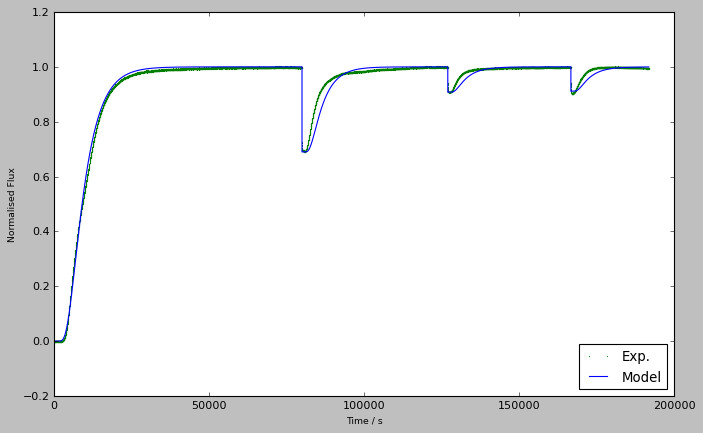

In [10]:
# Process exp data
experiment = 'S4R6'
data_path = Path.cwd().parent / 'data' / 'multi_pressure' / f'{experiment}.xlsx'
exp_data = pd.read_excel(data_path)
processed_data = preprocess_data(
    data=exp_data, 
    temperature= TEMPERATURE_DICT[experiment],
    thickness= THICKNESS_DICT[experiment], 
    flowrate= FLOWRATE_DICT[experiment],
    diameter= DIAMETER_DICT[experiment]
)

#----------------
# Step 1
#----------------
thickness = THICKNESS_DICT[experiment]
previous_D1_prime = 1.00
new_D1_prime = 2.759069935
DT_0 = 7.40E-09
step_1_data, T = process_step_exp_data(
    full_data=processed_data, 
    time_range = [0, 80e3], #* tune
    thickness=thickness, 
    DT_0=DT_0,
)
combined_exp_data = step_1_data.copy()

_, _, _, flux_df = calculate_plot_step_results(
    step_data=step_1_data,
    previous_D1_prime=previous_D1_prime,
    new_D1_prime=new_D1_prime,
    new_DT_0=DT_0,
    T=T,
    L=thickness,
    display_plot=False
)
combined_model_data = flux_df.copy()

#----------------
# Step 2
#----------------
thickness = THICKNESS_DICT[experiment]
previous_D1_prime = 2.759069935
new_D1_prime = 3.54960978
DT_0 = 7.37E-09

step_2_exp_data, T = process_step_exp_data(
    full_data=processed_data, 
    time_range = [102446.7, 149478.22], #* tune
    thickness=thickness, 
    DT_0=DT_0,
)
step_2_exp_data_adjusted = step_2_exp_data.copy()
step_2_exp_data_adjusted['time'] += combined_exp_data['time'].max()
combined_exp_data = pd.concat([combined_exp_data, step_2_exp_data_adjusted], ignore_index=True)

_, _, _, flux_df = calculate_plot_step_results(
    step_data=step_2_exp_data,
    previous_D1_prime=previous_D1_prime,
    new_D1_prime=new_D1_prime,
    new_DT_0=DT_0,
    T=T,
    L=thickness,
    display_plot=False
)
step_2_model_data_adjusted = flux_df.copy()
step_2_model_data_adjusted['time'] += combined_model_data['time'].max()
combined_model_data = pd.concat([combined_model_data, step_2_model_data_adjusted], ignore_index=True)

#----------------
# Step 3
#----------------
thickness = THICKNESS_DICT[experiment]
previous_D1_prime = 3.54960978
new_D1_prime = 3.808778288
DT_0 = 7.24E-09

step_3_exp_data, T = process_step_exp_data(
    full_data=processed_data, 
    time_range = [180285.9, 220000],    #* tune 
    thickness=thickness, 
    DT_0=DT_0,
)
step_3_exp_data_adjusted = step_3_exp_data.copy()
step_3_exp_data_adjusted['time'] += combined_exp_data['time'].max()
combined_exp_data = pd.concat([combined_exp_data, step_3_exp_data_adjusted], ignore_index=True)

_, _, _, flux_df = calculate_plot_step_results(
    step_data=step_3_exp_data,
    previous_D1_prime=previous_D1_prime,
    new_D1_prime=new_D1_prime,
    new_DT_0=DT_0,
    T=T,
    L=thickness,
    display_plot=False
)
step_3_model_data_adjusted = flux_df.copy()
step_3_model_data_adjusted['time'] += combined_model_data['time'].max()
combined_model_data = pd.concat([combined_model_data, step_3_model_data_adjusted], ignore_index=True)

#----------------
# Step 4
#----------------
thickness = THICKNESS_DICT[experiment]
previous_D1_prime = 3.808778288
new_D1_prime = 4.082026754
DT_0 = 6.96E-09

step_4_exp_data, T = process_step_exp_data(
    full_data=processed_data, 
    time_range = [264851.3, 290e3], #* tune
    thickness=thickness, 
    DT_0=DT_0,
)
step_4_data_adjusted = step_4_exp_data.copy()
step_4_data_adjusted['time'] += combined_exp_data['time'].max()
combined_exp_data = pd.concat([combined_exp_data, step_4_data_adjusted], ignore_index=True)

_, _, _, flux_df = calculate_plot_step_results(
    step_data=step_4_exp_data,
    previous_D1_prime=previous_D1_prime,
    new_D1_prime=new_D1_prime,
    new_DT_0=DT_0,
    T=T,
    L=thickness,
    display_plot=False
)
step_4_model_data_adjusted = flux_df.copy()
step_4_model_data_adjusted['time'] += combined_model_data['time'].max()
combined_model_data = pd.concat([combined_model_data, step_4_model_data_adjusted], ignore_index=True)

# Plot combined data
plt.figure(figsize=(10, 6))
plt.plot(combined_exp_data['time'], combined_exp_data['normalised_flux'], 'g.', markersize=1, linestyle='None', label='Exp.')
plt.plot(combined_model_data['time'], combined_model_data['normalised_flux'], 'b-', linewidth=1, label='Model')
plt.xlabel('Time / s')
plt.ylabel('Normalised Flux')
plt.legend(loc='lower right')
plt.show()

# Export combined data
combined_exp_data.to_csv(Path.cwd() / f'{experiment}_exp_data.csv', index=False)
combined_model_data.to_csv(Path.cwd() / f'{experiment}_model_data.csv', index=False)